In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

2023-08-07 11:24:28.078141: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-07 11:24:28.131907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 11:24:29.260576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-07 11:24:30.281402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at http

In [2]:
candidate_sentences = pd.read_csv("/var/basefolder_smit/largelm/localdata/input_data.txt-out.csv")
candidate_sentences.shape

(36, 3)

In [3]:
candidate_sentences

,Godfather,is,1972 film
0,Godfather,is,1972 film by Francis Ford Coppola
1,It,is renowned for,its technical excellence
2,It,is,renowned
3,It,is renowned for,its excellence
4,Cinematographer Gordon Willis,created,style
5,Cinematographer Gordon Willis,created,visual style
6,Cinematographer Gordon Willis,created,distinctive style
7,Cinematographer Gordon Willis,created,distinctive visual style
8,Dark interiors,showed,skillful lighting
9,interiors,showed,lighting


In [4]:
candidate_sentences.columns[0]

'Godfather '

In [5]:
df = pd.DataFrame({'source': candidate_sentences[candidate_sentences.columns[0]], 'edge': candidate_sentences[candidate_sentences.columns[1]], 'target': candidate_sentences[candidate_sentences.columns[2]]})
df

,source,edge,target
0,Godfather,is,1972 film by Francis Ford Coppola
1,It,is renowned for,its technical excellence
2,It,is,renowned
3,It,is renowned for,its excellence
4,Cinematographer Gordon Willis,created,style
5,Cinematographer Gordon Willis,created,visual style
6,Cinematographer Gordon Willis,created,distinctive style
7,Cinematographer Gordon Willis,created,distinctive visual style
8,Dark interiors,showed,skillful lighting
9,interiors,showed,lighting


In [6]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [7]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [8]:
G.nodes

NodeView(('Godfather ', ' 1972 film by Francis Ford Coppola', 'It ', ' its technical excellence', ' renowned', ' its excellence', 'Cinematographer Gordon Willis ', ' style', ' visual style', ' distinctive style', ' distinctive visual style', 'Dark interiors ', ' skillful lighting', 'interiors ', ' lighting', ' duality', 'Editing ', ' story', 'Scenes ', ' suspense', ' juxtaposed', 'Sound design ', ' authenticity', 'design ', "Nino Rota 's score ", ' mood', 'Nino Rota ', ' score', 'effects ', ' subtle', 'Visual effects ', ' subtle effective', ' subtle yet effective', 'Practical elements ', ' design', ' crucial', ' set design', 'Costumes ', ' character portrayal', ' makeup', 'Settings ', ' themes', 'Close-ups ', ' emotions'))

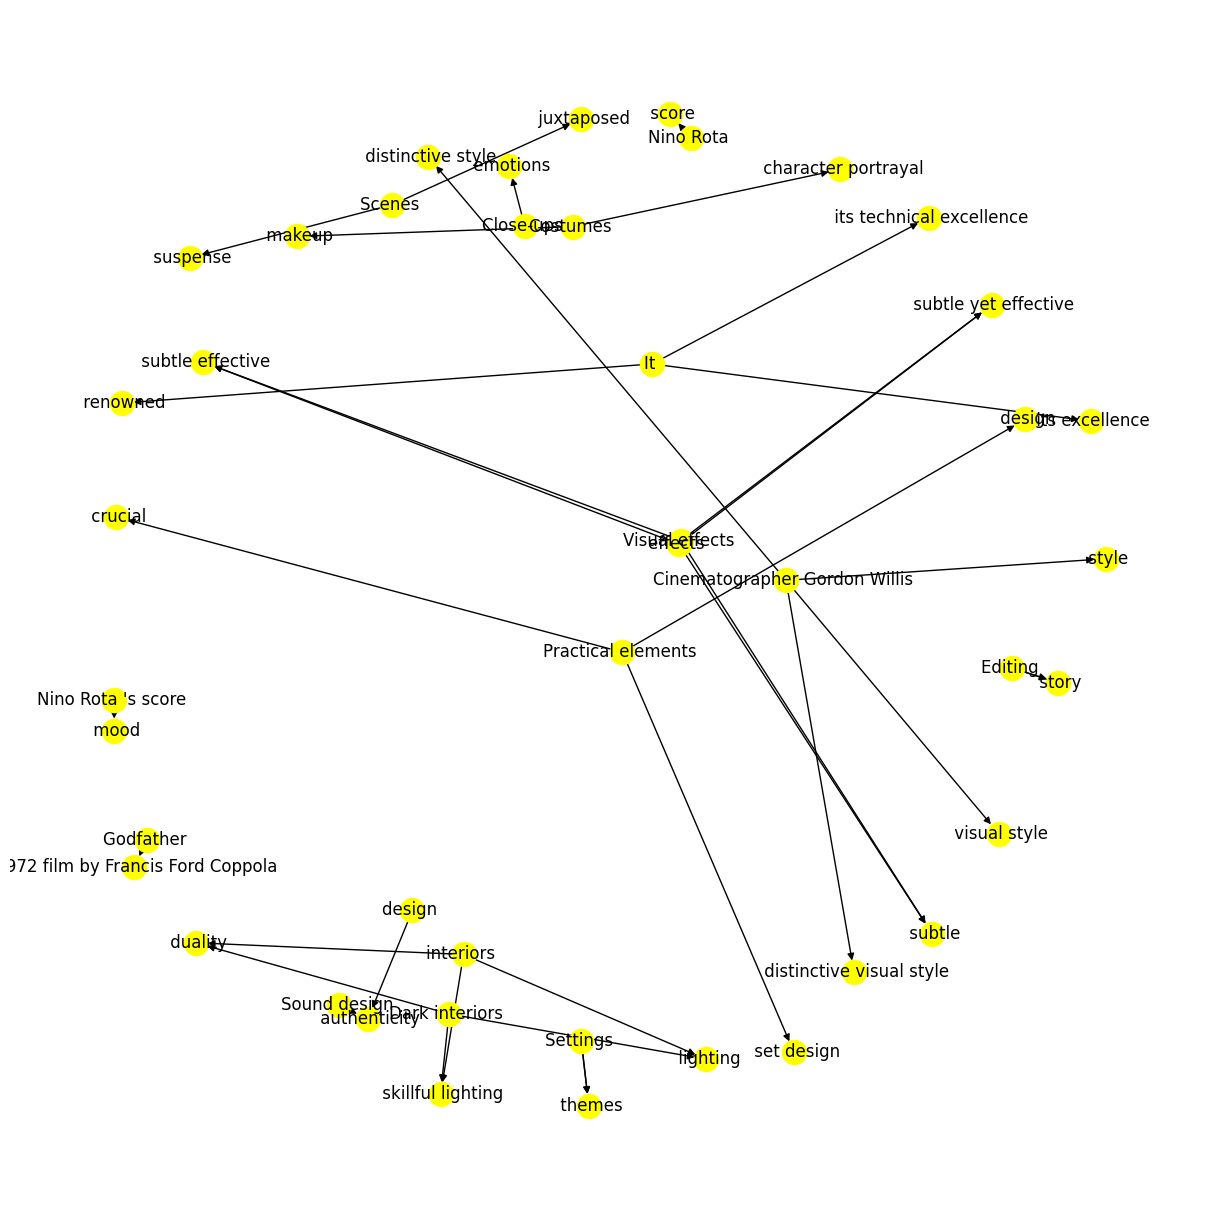

In [9]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='yellow', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()